In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('../data/data.csv')
StarPlayer = pd.read_csv('../data/StarPlayer.csv')
StarPres = pd.read_csv('../data/StarPresence.csv')

In [2]:
# create numstars
numstars = (StarPlayer.groupby(['Year','Team'])
                  .size()
                  .reset_index(name='NumStars')\
                    .fillna({'NumStars': 0}))
numstars.head()

,Year,Team,NumStars
0,2011,Atlanta Hawks,1
1,2011,Chicago Bulls,1
2,2011,Dallas Mavericks,1
3,2011,Los Angeles Lakers,2
4,2011,Menphis Grizzlies,1


In [3]:
# merge star player and star presence
star = (df
      .merge(StarPres, on=['Year','Team'], how='left')
      .merge(numstars, on=['Year','Team'], how='left'))

# fillna and convert to int
star[['StarPresence','NumStars']] = star[['StarPresence','NumStars']].fillna(0).astype(int)

In [4]:
# add star arrival
star = star.sort_values(['Team','Year'])
star['StarArrival'] = (
    star.groupby('Team')['StarPresence']
      .diff()               # ΔPresence
      .fillna(0)
      .eq(1)                # True if 0→1
      .astype(int)
)
star.to_csv('../data/data_star.csv', index=False)

In [5]:
df = pd.read_csv('../data/data_star.csv')

In [ ]:
# drop 2022-2025 due to the timing of the data
df = df[df['Year'] < 2022]

,Year,Team,Valuation,CPI,RealValuation,LogValuation,StarArrival,StarPresence,NumStars
456,2017,Washington Wizards,1.000000e+09,245.1,1.314973e+09,20.997082,1,1,1
457,2018,Washington Wizards,1.350000e+09,251.1,1.732796e+09,21.273002,0,0,0
458,2019,Washington Wizards,1.550000e+09,255.7,1.953715e+09,21.392999,0,0,0
459,2020,Washington Wizards,1.750000e+09,258.8,2.179386e+09,21.502309,0,0,0
460,2021,Washington Wizards,1.800000e+09,271.0,2.140738e+09,21.484416,1,1,1


## EDA

In [8]:
df.describe()

,Year,Valuation,CPI,RealValuation,LogValuation,StarArrival,StarPresence,NumStars
count,341.000000,3.410000e+02,341.000000,3.410000e+02,341.000000,341.000000,341.000000,341.000000
mean,2016.000000,1.225685e+09,243.900000,1.579534e+09,20.956714,0.129032,0.372434,0.469208
std,3.166925,8.981045e+08,13.326764,1.100398e+09,0.677361,0.335728,0.484164,0.683690
min,2011.000000,2.580000e+08,224.900000,3.697350e+08,19.728297,0.000000,0.000000,0.000000
25%,2013.000000,4.970000e+08,233.000000,6.976616e+08,20.363245,0.000000,0.000000,0.000000
50%,2016.000000,1.000000e+09,240.000000,1.342917e+09,21.018110,0.000000,0.000000,0.000000
75%,2019.000000,1.600000e+09,255.700000,1.989506e+09,21.411152,0.000000,1.000000,1.000000
max,2021.000000,5.000000e+09,271.000000,5.946494e+09,22.506068,1.000000,1.000000,3.000000


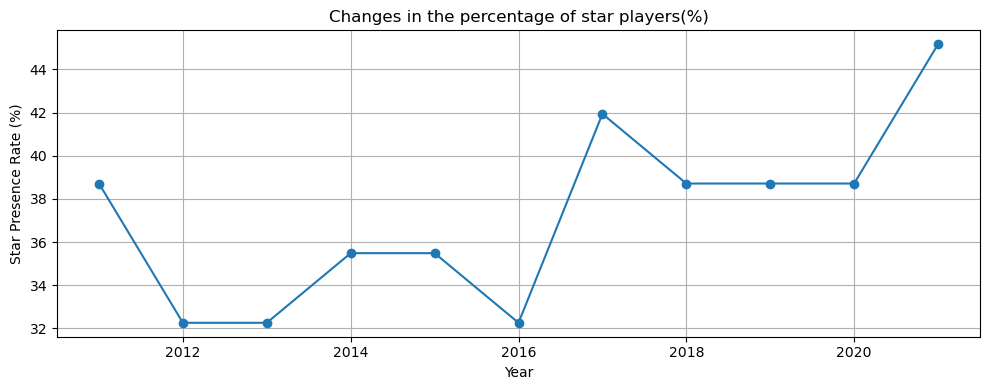

In [9]:
star_rate = df.groupby("Year")["StarPresence"].mean() * 100

plt.figure(figsize=(10, 4))
plt.plot(star_rate.index, star_rate.values, marker="o")
plt.title("Changes in the percentage of star players(%)")
plt.xlabel("Year")
plt.ylabel("Star Presence Rate (%)")
plt.grid(True)
plt.tight_layout()
plt.show()

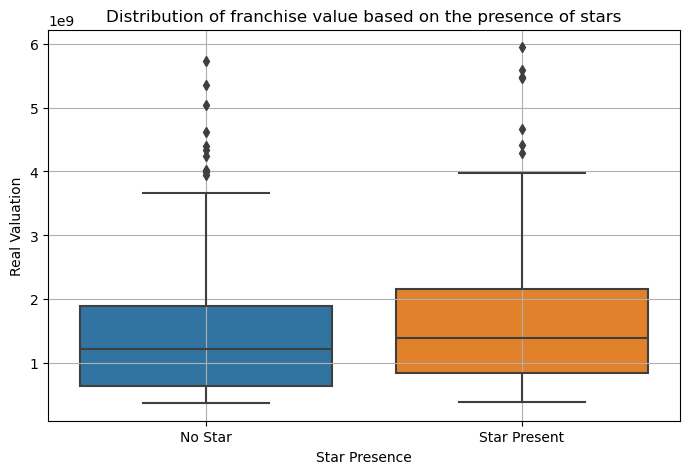

In [10]:
plt.figure(figsize=(7, 5))
sns.boxplot(x="StarPresence", y="RealValuation", data=df)
plt.xticks([0, 1], ["No Star", "Star Present"])
plt.title("Distribution of franchise value based on the presence of stars")
plt.xlabel("Star Presence")
plt.ylabel("Real Valuation")
plt.grid(True)
plt.tight_layout()
plt.show()


In [11]:
import statsmodels.formula.api as smf

m1 = smf.ols("LogValuation ~ StarPresence + C(Team) + C(Year)", data=df)\
        .fit(cov_type="cluster", cov_kwds={"groups": df["Team"]})

m1.summary().tables[1]

c:\Users\shoku\anaconda3\Lib\site-packages\statsmodels\base\model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 41, but rank is 11
  warnings.warn('covariance of constraints does not have full '


,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,19.7515,0.034,573.619,0.000,19.684,19.819
C(Team)[T.Boston Celtics],0.7433,0.006,119.232,0.000,0.731,0.756
C(Team)[T.Brooklyn Nets],0.5330,0.002,341.977,0.000,0.530,0.536
C(Team)[T.Charlotte Hornets],-0.0507,4.04e-14,-1.26e+12,0.000,-0.051,-0.051
C(Team)[T.Chicago Bulls],0.8476,0.002,543.851,0.000,0.845,0.851
C(Team)[T.Cleveland Cavaliers],0.1543,0.003,49.507,0.000,0.148,0.160
C(Team)[T.Dallas Mavericks],0.5159,0.003,165.492,0.000,0.510,0.522
C(Team)[T.Denver Nuggets],0.0831,0.002,53.316,0.000,0.080,0.086
C(Team)[T.Detroit Pistons],0.0524,5e-14,1.05e+12,0.000,0.052,0.052
C(Team)[T.Golden State Warriors],0.7497,0.009,80.176,0.000,0.731,0.768


In [12]:
m2 = smf.ols("LogValuation ~ StarArrival + StarPresence + C(Team) + C(Year)", data=df)\
        .fit(cov_type="cluster", cov_kwds={"groups": df["Team"]})

m2.summary().tables[1]


c:\Users\shoku\anaconda3\Lib\site-packages\statsmodels\base\model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 42, but rank is 12
  warnings.warn('covariance of constraints does not have full '


,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,19.7441,0.035,572.215,0.000,19.676,19.812
C(Team)[T.Boston Celtics],0.7393,0.007,106.812,0.000,0.726,0.753
C(Team)[T.Brooklyn Nets],0.5353,0.002,254.638,0.000,0.531,0.539
C(Team)[T.Charlotte Hornets],-0.0452,0.002,-21.943,0.000,-0.049,-0.041
C(Team)[T.Chicago Bulls],0.8507,0.001,616.531,0.000,0.848,0.853
C(Team)[T.Cleveland Cavaliers],0.1496,0.004,35.577,0.000,0.141,0.158
C(Team)[T.Dallas Mavericks],0.5111,0.004,121.559,0.000,0.503,0.519
C(Team)[T.Denver Nuggets],0.0807,0.002,38.401,0.000,0.077,0.085
C(Team)[T.Detroit Pistons],0.0579,0.002,28.101,0.000,0.054,0.062
C(Team)[T.Golden State Warriors],0.7411,0.011,66.877,0.000,0.719,0.763


c:\Users\shoku\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1883: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_params()))


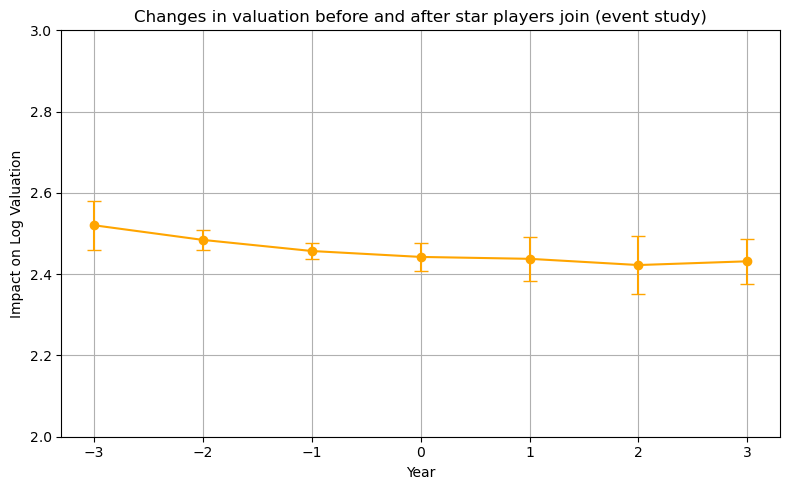

In [19]:
arrival_years = df[df["StarArrival"] == 1][["Team", "Year"]].rename(columns={"Year": "ArrivalYear"})
es = df.merge(arrival_years, on="Team", how="left")

es["k"] = es["Year"] - es["ArrivalYear"]

es = es[es["k"].between(-3, 3)]

for i in [-3, -2, -1, 0, 1, 2, 3]:
    col_name = f"D_minus{abs(i)}" if i < 0 else f"D_{i}"
    es[col_name] = (es["k"] == i).astype(int)

dummies = [f"D_minus{abs(i)}" if i < 0 else f"D_{i}" for i in [-3, -2, -1, 0, 1, 2, 3]]
fmla = "LogValuation ~ " + " + ".join(dummies) + " + C(Team) + C(Year)"
m_es = smf.ols(fmla, data=es).fit(cov_type="cluster", cov_kwds={"groups": es["Team"]})

coefs = m_es.params[dummies]
errs = m_es.bse[dummies]
x_vals = [-3, -2, -1, 0, 1, 2, 3]

plt.figure(figsize=(8, 5))
plt.errorbar(x_vals, coefs, yerr=1.96 * errs, fmt="o-", capsize=5, color='orange')
plt.axhline(0, color="gray", linestyle="--")
plt.title("Changes in valuation before and after star players join (event study)")
plt.xlabel("Year")
plt.ylabel("Impact on Log Valuation")
plt.grid(True)
plt.ylim(2.0, 3.0)
plt.tight_layout()
plt.show()
